In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [2]:
class Tensor:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = np.zeros_like(data)
        self.grad2 = np.zeros_like(data)
        self._backward = lambda: None
        self._backward_second_order = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.requires_grad = True

    def shape(self):
        return self.data.shape

    def __repr__(self):
        return str(self.data)
    
    def __add__(self, other):
        if isinstance(other, Tensor):
            out = Tensor(self.data + other.data, (self, other), '+', label=f'{self.label}+{other.label}')
        else:
            out = Tensor(self.data + other, (self,), '+')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2 + self.grad2
                    if isinstance(other, Tensor) and other.requires_grad:
                         other.grad2 = out.grad2 + other.grad2
                else:
                    self.grad = out.grad + self.grad
                    if isinstance(other, Tensor) and other.requires_grad:
                        other.grad = out.grad + other.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def __sub__(self, other):
        if isinstance(other, Tensor):
            out = Tensor(self.data - other.data, (self, other), '-', label=f'{self.label}-{other.label}')
        else:
            out = Tensor(self.data - other, (self,), '-')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2 + self.grad2
                    if isinstance(other, Tensor) and other.requires_grad:
                         other.grad2 = -out.grad2 + other.grad2
                else:
                    self.grad = out.grad + self.grad
                    if isinstance(other, Tensor) and other.requires_grad:
                        other.grad = -out.grad + other.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def __mul__(self, other):
        if isinstance(other, Tensor):
            out = Tensor(self.data * other.data, (self, other), '*', label=f'{self.label}*{other.label}')
        else:
            out = Tensor(self.data * other, (self,), '*')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    if isinstance(other, Tensor):
                         self.grad2 = out.grad2 * other.data + self.grad2
                         if other.requires_grad:
                            other.grad2 = out.grad2 * self.data + other.grad2
                    else:
                         self.grad2 = out.grad2 * other + self.grad2
                else:    
                    if isinstance(other, Tensor):
                        self.grad = out.grad * other.data + self.grad
                        if other.requires_grad:
                            other.grad = out.grad * self.data + other.grad
                    else:
                        self.grad = out.grad * other + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def __getitem__(self, index):
        data = self.data[index]
        out = Tensor(data, (self,), 'getitem', label=f'{self.label}[{index}]')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                     self.grad2[index] = out.grad2 + self.grad2[index]
                else:
                    self.grad[index] = out.grad + self.grad[index]

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return Tensor(-self.data, (self,), 'neg', label=f'-{self.label}')
    
    def __rsub__(self, other):
        return -self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, exponent: float):
        data = self.data**exponent
        out = Tensor(data, (self,), f'**{exponent}', label=f'{self.label}**{exponent}')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2 * exponent * (exponent-1) * self.data ** (exponent - 2) + self.grad2
                else:
                    self.grad = out.grad * exponent * self.data ** (exponent - 1) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def dot(self, other):
        out_data = np.matmul(self.data, other.data)
        out = Tensor(out_data, (self, other), 'matmul', label=f'{self.label} matmul {other.label}')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    if isinstance(out.grad2, Tensor):
                        self.grad2 = out.grad2.dot(other.swapaxes(-1,-2)) + self.grad2
                        if other.requires_grad:
                            other.grad2 = self.swapaxes(-2,-1).dot(out.grad2) + other.grad2
                    else:
                        self.grad2 += np.matmul(out.grad2, other.data.swapaxes(-1, -2))
                        if other.requires_grad:
                            other.grad2 += np.matmul(self.data.swapaxes(-2, -1), out.grad2)
                else:
                    if isinstance(out.grad, Tensor):
                        self.grad = out.grad.dot(other.swapaxes(-1,-2)) + self.grad
                        if other.requires_grad:
                            other.grad = self.swapaxes(-2,-1).dot(out.grad) + other.grad
                    else:
                        self.grad += np.matmul(out.grad, other.data.swapaxes(-1, -2))
                        if other.requires_grad:
                            other.grad += np.matmul(self.data.swapaxes(-2, -1), out.grad)
                

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def T(self, axes=None):
        data = np.transpose(self.data, axes)
        out = Tensor(data, (self,), 'transpose', label=f'{self.label}.T')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if axes is None:
                    axes_inv = None
                else:
                    axes_inv = np.argsort(axes)
                
                if secondOrder:
                    if isinstance(out.grad2, Tensor):
                         self.grad2 = out.grad2.T(axes_inv) + self.grad2
                    else:
                         self.grad2 += np.transpose(out.grad2, axes_inv)
                else:
                    if isinstance(out.grad, Tensor):
                        self.grad = out.grad.T(axes_inv) + self.grad
                    else:
                        self.grad += np.transpose(out.grad, axes_inv)

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def swapaxes(self, axis1, axis2):
        data = np.swapaxes(self.data, axis1, axis2)
        out = Tensor(data, (self,), 'swapaxes', label=f'{self.label}.swapaxes({axis1}, {axis2})')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2.swapaxes(axis1, axis2) + self.grad2
                else:
                    self.grad = out.grad.swapaxes(axis1, axis2) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def sum(self, axis=None, keepdims=False):
        data = self.data.sum(axis=axis, keepdims=keepdims)
        out = Tensor(data, (self,), 'sum', label=f'{self.label} sum')

        def _backward(axis=axis, secondOrder=False):
            if self.requires_grad:
                grad_shape = np.ones_like(self.data.shape)
                if axis is not None:
                    if isinstance(axis, int):
                        axis = (axis,)
                    for ax in axis:
                        grad_shape[ax] = self.data.shape[ax]
                
                if secondOrder:
                    self.grad2 = out.grad2 * np.ones_like(self.data) + self.grad2
                else:
                    self.grad = out.grad * np.ones_like(self.data) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def flatten(self):
        data = self.data.flatten()
        out = Tensor(data, (self,), 'flatten', label=f'{self.label} flatten')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = out.grad2.reshape(self.data.shape) + self.grad2
                else:
                    self.grad = out.grad.reshape(self.data.shape) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def relu(self):
        data = np.maximum(0, self.data)
        out = Tensor(data, (self,), 'relu', label=f'{self.label} relu')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = self.grad2
                else:
                    self.grad = out.grad * (self.data > 0) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def leaky_relu(self):
        data = np.maximum(0.01 * self.data, self.data)
        out = Tensor(data, (self,), 'leaky relu', label=f'{self.label} leaky relu')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = self.grad2
                else:
                    self.grad = out.grad * (self.data > 0) +  out.grad * (0.01 * (self.data < 0))

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out
    
    def tanh(self):
        data = np.tanh(self.data)
        out = Tensor(data, (self,), 'tanh', label=f'{self.label} tanh')

        def _backward(secondOrder=False):
            if self.requires_grad:
                if secondOrder:
                    self.grad2 = -2 * out.grad2 * data * (1-data**2) + self.grad2
                else:
                    self.grad = out.grad * (1 - data**2) + self.grad

        out._backward = partial(_backward, secondOrder=False)
        out._backward_second_order = partial(_backward, secondOrder=True)
        return out

    def backward(self, secondOrder=False, hessian=False):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        if not hessian:
            self.grad = (1.0 * np.ones_like(self.data))
            if secondOrder:
                self.grad = Tensor(self.grad, label='grad')
                self.grad2 = 1.0 * np.ones_like(self.data)
                
            for node in reversed(topo):
                node._backward()

        else:
            self.grad2 = (1.0 * np.ones_like(self.data))
            for node in reversed(topo):
                node._backward_second_order()


    def get_hessian(self):
        """Get the Hessian of this tensor w.r.t. another tensor out."""
        
        n = self.data.shape[0]
        hessian = np.zeros((n, n))

        for i in range(n):
            # Do backward pass wrt i-th element of the gradient
            self.grad[i].backward(hessian=True)

            hessian[:,i] = self.grad2.squeeze()

            self.grad[i].zero_grad2()

        return hessian

    def zero_grad2(self):
        """Resets gradients of this tensor and all its descendants to zero."""
        self.grad2 = np.zeros_like(self.data)

        for child in self._prev:
            if isinstance(child, Tensor) and child.requires_grad:
                child.zero_grad2()

In [3]:
# Check gradient and hessian of xT Q x
x = Tensor(np.random.randn(5, 1), label='x')
Q = Tensor(np.random.randn(5, 5), label='Q')
y = x.T().dot(Q).dot(x)

y.backward(secondOrder=True)

print("Gradient")

print(x.grad)
print(Q.data @ x.data + Q.data.T @ x.data)

print(f'{'='*80}\n Hessian')

print(x.get_hessian())
print("Verification:\n", Q.data + Q.data.T)

Gradient
[[-2.51046357]
 [-2.65634949]
 [-2.15366375]
 [-0.26748733]
 [-0.6359458 ]]
[[-2.51046357]
 [-2.65634949]
 [-2.15366375]
 [-0.26748733]
 [-0.6359458 ]]
 Hessian
[[-2.21489139  1.76092128  1.02574771 -3.18959525  2.17149803]
 [ 1.76092128 -1.13746101  0.60824411 -1.67380545  0.47511074]
 [ 1.02574771  0.60824411 -1.13185826 -1.07725548  0.0080717 ]
 [-3.18959525 -1.67380545 -1.07725548 -0.06008594  0.50800536]
 [ 2.17149803  0.47511074  0.0080717   0.50800536  0.52646613]]
Verification:
 [[-2.21489139  1.76092128  1.02574771 -3.18959525  2.17149803]
 [ 1.76092128 -1.13746101  0.60824411 -1.67380545  0.47511074]
 [ 1.02574771  0.60824411 -1.13185826 -1.07725548  0.0080717 ]
 [-3.18959525 -1.67380545 -1.07725548 -0.06008594  0.50800536]
 [ 2.17149803  0.47511074  0.0080717   0.50800536  0.52646613]]


In [4]:
class SimpleMLP:
    def __init__(self, layer_sizes):
        self.params = []
        self.layers = len(layer_sizes) - 1

        for i in range(self.layers):
            self.params.append(Tensor(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01))
            self.params.append(Tensor(np.zeros((1, layer_sizes[i+1]))))

    def forward(self, x):
        for i in range(self.layers):
            x = x.dot(self.params[2*i]) + self.params[2*i+1]
            if i < self.layers - 1:
                x = x.leaky_relu()
        self.z = x
        return x

    def backward(self, y):
        loss = ((self.z - y) ** 2).sum() / Tensor(y.data.shape[0]*1.0)  # MSE
        loss.backward()  # Use autograd to calculate gradients

        return loss

In [5]:
class SGD:
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr

    def step(self):
        for param in self.model.params:
            param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.model.params:
            param.grad = np.zeros_like(param.grad)

class Adam:
    def __init__(self, model, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.model = model
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = [Tensor(np.zeros_like(param.data)) for param in model.params]
        self.v = [Tensor(np.zeros_like(param.data)) for param in model.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.model.params):
            if param.grad.shape != param.data.shape:
                param.grad = param.grad.sum(axis=0)
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad**2
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            param.data -= self.lr * m_hat.data / (np.sqrt(v_hat.data) + self.epsilon)

    def zero_grad(self):
        for param in self.model.params:
            param.grad *= 0

In [14]:
X = np.linspace(-2 * np.pi, 2 * np.pi, 100).reshape(-1, 1)
Y = np.sin(X)

mlp = SimpleMLP([1,50,20,1])
optimizer = Adam(mlp, lr=1e-1)

x_tensor = Tensor(X)
y_tensor = Tensor(Y)

Epoch 100/200: Loss: 0.0051616864058383494
Epoch 200/200: Loss: 0.0005930513911028143


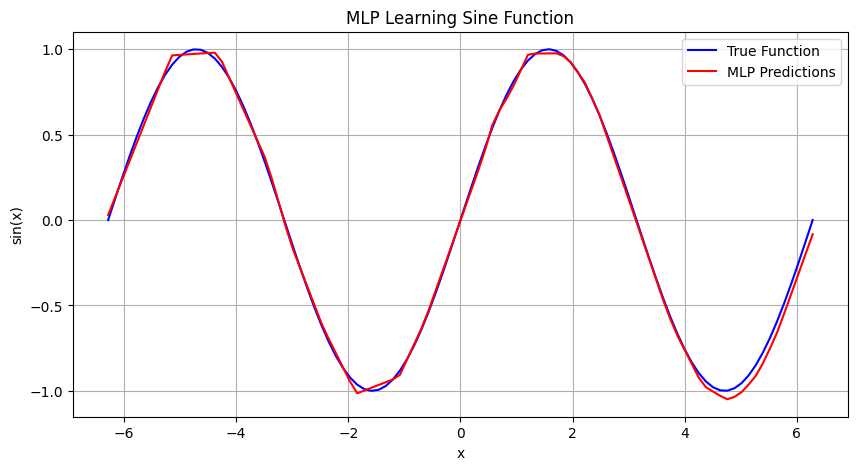

In [15]:
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = mlp.forward(x_tensor)
    loss = mlp.backward(y_tensor)
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}: Loss: {loss.data}')

test_x = np.linspace(-2 * np.pi, 2 * np.pi, 100).reshape(-1, 1)
test_tensor = Tensor(test_x)
test_predictions = mlp.forward(test_tensor)

plt.figure(figsize=(10, 5))
plt.plot(test_x, np.sin(test_x), label='True Function', color='blue')
plt.plot(test_x, test_predictions.data, label='MLP Predictions', color='red')
plt.legend()
plt.title('MLP Learning Sine Function')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.grid()
plt.show()